<a href="https://colab.research.google.com/github/simoneseverini/automated-discovery-site/blob/main/Digraphs_Hessemberg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2575124582.py:15: SyntaxWarning: invalid escape sequence '\d'
  4.  **Hamiltonicity (Cor 15):** All $D_n(S)$ contain the directed Hamilton cycle $1 \to n \to n-1 \dots \to 1$.


Environment: Numpy 2.0.2, NetworkX 3.6.1, Pandas 2.2.2
Test 1: Matrix Factorization vs Closed Form...
  -> Passed 50/50 trials.
Test 2: Numerical Digraph vs Combinatorial Model...
  -> Passed 50/50 trials.
Test 3: Connectivity, Hamiltonicity, and Degrees...
  -> Passed 50/50 trials.
Test 4: Rigidity (Trivial Automorphism Group for |S|>=2)...
  -> Passed 50/50 trials.
Test 5: Isomorphism Counting (n=2..10)...

Enumeration Results:


,n,Total S,Non-Iso (Count),Formula,Match
0,2,2,2,2,True
1,3,4,3,3,True
2,4,8,7,7,True
3,5,16,14,14,True
4,6,32,30,30,True
5,7,64,61,61,True
6,8,128,125,125,True
7,9,256,252,252,True
8,10,512,508,508,True



SUCCESS: All verifications passed in 2.92 seconds.

--- Visualization of Example D_5({2,4}) ---


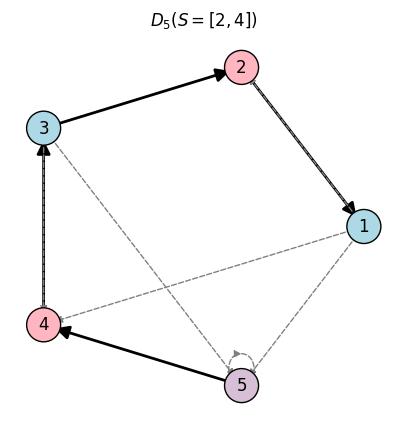

In [1]:
# -*- coding: utf-8 -*-
"""Digraphs_of_Hessenberg_Matrices_Verification.ipynb

Automatically generated by Colab.

# Verification Suite: Digraphs of Real Orthogonal Upper Hessenberg Matrices

This notebook numerically and combinatorially verifies the theorems presented in the paper
**"Digraphs of Real Orthogonal Upper Hessenberg Matrices"**.

**Theorems Verified:**
1.  **Factorization & Entries (Prop 5):** The product of Givens rotations matches the explicit closed-form entry formula.
2.  **Structure (Thm 10):** The numerical support digraph $D(Q)$ matches the combinatorial definition $D_n(S)$.
3.  **Connectivity (Cor 12):** Unreduced matrices yield strongly connected digraphs; breaks ($\alpha_k=0$) yield disconnected ones.
4.  **Hamiltonicity (Cor 15):** All $D_n(S)$ contain the directed Hamilton cycle $1 \to n \to n-1 \dots \to 1$.
5.  **Degrees (Prop 16):** The explicit in/out-degree formulas hold.
6.  **Rigidity (Thm 18):** For $|S| \ge 2$, the automorphism group is trivial.
7.  **Enumeration (Thm 19):** The number of non-isomorphic connected support digraphs is $2^{n-1} - \lfloor \frac{n-1}{2} \rfloor$.
"""

import math
import random
import itertools
import time
import warnings
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms.isomorphism import DiGraphMatcher
import matplotlib.pyplot as plt

# Suppress minor warnings for cleaner output
warnings.filterwarnings("ignore")

# --- Configuration ---
RANDOM_SEED = 42
TOLERANCE = 1e-12       # Threshold for considering a float entry non-zero
N_MAX_ISO_CHECK = 10    # Max n for exhaustive isomorphism counting (n=10 is ~512 graphs)
N_TRIALS = 50           # Number of random trials for stochastic checks

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"Environment: Numpy {np.__version__}, NetworkX {nx.__version__}, Pandas {pd.__version__}")

# =============================================================================
# 1. Mathematical Definitions (Matrix & Combinatorial)
# =============================================================================

def givens_rotation(n: int, k: int, alpha: float) -> np.ndarray:
    """Returns the n x n Givens rotation matrix G_k(alpha)."""
    beta = 1.0 - alpha
    c = math.sqrt(beta)
    s = math.sqrt(alpha)
    G = np.eye(n)
    # G acts on rows/cols k-1 and k (0-indexed)
    idx = k - 1
    G[idx, idx] = c
    G[idx, idx+1] = s
    G[idx+1, idx] = -s
    G[idx+1, idx+1] = c
    return G

def matrix_from_givens(n: int, alphas: list) -> np.ndarray:
    """Computes Q = G_1 ... G_{n-1} via matrix multiplication."""
    Q = np.eye(n)
    for k, alpha in enumerate(alphas, start=1):
        Q = Q @ givens_rotation(n, k, alpha)
    return Q

def matrix_from_formula(n: int, alphas: list) -> np.ndarray:
    """Computes Q using the explicit closed-form entries (Proposition 5)."""
    Q = np.zeros((n, n))
    # Precompute betas (beta_k = 1 - alpha_k)
    # alphas is 0-indexed: alpha_1 is alphas[0]
    beta = [1.0] + [1.0 - a for a in alphas] + [1.0]

    for i in range(1, n + 1):
        for j in range(1, n + 1):
            if i > j + 1:
                val = 0.0
            elif i == j + 1:
                # Subdiagonal: -sqrt(alpha_j)
                val = -math.sqrt(alphas[j-1])
            else:
                # Upper part: sqrt(beta_{i-1}) * prod(sqrt(alpha)) * sqrt(beta_j)
                term = math.sqrt(beta[i-1]) * math.sqrt(beta[j])
                prod_alpha = 1.0
                for t in range(i, j):
                    prod_alpha *= math.sqrt(alphas[t-1])
                val = term * prod_alpha
            Q[i-1, j-1] = val
    return Q

def digraph_from_matrix(Q: np.ndarray, tol: float = TOLERANCE) -> nx.DiGraph:
    """Extracts support digraph D(Q) from numerical matrix."""
    n = Q.shape[0]
    G = nx.DiGraph()
    G.add_nodes_from(range(1, n + 1))
    rows, cols = np.where(np.abs(Q) > tol)
    for r, c in zip(rows, cols):
        G.add_edge(r + 1, c + 1)
    return G

def digraph_combinatorial(n: int, S: set) -> nx.DiGraph:
    """Constructs the digraph D_n(S) defined in Theorem 10."""
    G = nx.DiGraph()
    G.add_nodes_from(range(1, n + 1))

    # Active sets
    R = {1} | {k + 1 for k in S}
    C = S | {n}

    # 1. Spine (Subdiagonal)
    for k in range(1, n):
        G.add_edge(k + 1, k)

    # 2. Upper Triangle (Interaction of R and C)
    for i in R:
        for j in C:
            if i <= j:
                G.add_edge(i, j)
    return G

# =============================================================================
# 2. Visualization (Optional)
# =============================================================================

def plot_digraph(n, S, ax=None):
    """Visualizes D_n(S) with coloring matching the paper's description."""
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))

    G = digraph_combinatorial(n, S)
    pos = nx.circular_layout(G)

    # Identify R and C nodes
    R = {1} | {k + 1 for k in S}
    C = S | {n}

    node_colors = []
    for v in G.nodes():
        if v in R and v in C:
            node_colors.append('#D8BFD8') # Thistle (Purple-ish)
        elif v in R:
            node_colors.append('#ADD8E6') # Light Blue
        elif v in C:
            node_colors.append('#FFB6C1') # Light Pink
        else:
            node_colors.append('#E0E0E0') # Grey

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=600, edgecolors='k', ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)

    # Edges
    spine = [(u, v) for u, v in G.edges() if u == v + 1]
    others = [(u, v) for u, v in G.edges() if u != v + 1]

    nx.draw_networkx_edges(G, pos, edgelist=spine, edge_color='black', width=2.0, arrowsize=20, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=others, edge_color='gray', style='dashed', width=1.0, ax=ax)

    ax.set_title(f"$D_{{{n}}}(S={{{list(sorted(S))}}})$")
    ax.axis('off')

# =============================================================================
# 3. Verification Functions
# =============================================================================

def verify_matrix_entries():
    """Check if Matrix Product == Closed Form Formula."""
    print("Test 1: Matrix Factorization vs Closed Form...")
    results = []
    for _ in range(N_TRIALS):
        n = random.randint(3, 15)
        alphas = np.random.rand(n - 1) # generic values
        Q_prod = matrix_from_givens(n, alphas)
        Q_form = matrix_from_formula(n, alphas)
        err = np.max(np.abs(Q_prod - Q_form))
        results.append(err < TOLERANCE)

    print(f"  -> Passed {sum(results)}/{N_TRIALS} trials.")
    return all(results)

def verify_digraph_equivalence():
    """Check if Numerical Support D(Q) == Combinatorial D_n(S)."""
    print("Test 2: Numerical Digraph vs Combinatorial Model...")
    results = []
    for _ in range(N_TRIALS):
        n = random.randint(3, 15)
        # Generate random S
        S = set(random.sample(range(1, n), k=random.randint(0, n-1)))

        # Map S to parameters:
        # k in S -> alpha generic (0.5)
        # k not in S -> alpha pivot (1.0)
        alphas = []
        for k in range(1, n):
            alphas.append(0.5 if k in S else 1.0)

        Q = matrix_from_givens(n, alphas)
        G_num = digraph_from_matrix(Q)
        G_com = digraph_combinatorial(n, S)

        # Check strict edge equality (vertices are labeled 1..n)
        equiv = (set(G_num.edges()) == set(G_com.edges()))
        results.append(equiv)

    print(f"  -> Passed {sum(results)}/{N_TRIALS} trials.")
    return all(results)

def verify_properties():
    """Check Connectivity, Hamiltonicity, and Degree Formulas."""
    print("Test 3: Connectivity, Hamiltonicity, and Degrees...")
    passes = 0
    for _ in range(N_TRIALS):
        n = random.randint(3, 15)
        S = set(random.sample(range(1, n), k=random.randint(0, n-1)))
        G = digraph_combinatorial(n, S)

        # 1. Strong Connectivity
        if not nx.is_strongly_connected(G):
            return False

        # 2. Hamilton Cycle (1->n->n-1...->1)
        # Edges needed: (1,n) and spine (k+1, k)
        has_cycle = G.has_edge(1, n) and all(G.has_edge(k+1, k) for k in range(1, n))
        if not has_cycle:
            return False

        # 3. Degrees
        m = len(S)
        C = S | {n}
        # Check specific formula for d+(1) = m+1
        if G.out_degree(1) != m + 1:
            return False
        # Check d-(n) = m+1
        if G.in_degree(n) != m + 1:
            return False

        passes += 1
    print(f"  -> Passed {passes}/{N_TRIALS} trials.")
    return True

def verify_rigidity():
    """Check Theorem 18: |S|>=2 => Trivial Automorphism Group."""
    print("Test 4: Rigidity (Trivial Automorphism Group for |S|>=2)...")
    passes = 0
    count_checked = 0
    for _ in range(N_TRIALS):
        n = random.randint(4, 12)
        # Ensure |S| >= 2
        k = random.randint(2, n-1)
        S = set(random.sample(range(1, n), k))

        G = digraph_combinatorial(n, S)
        matcher = DiGraphMatcher(G, G)
        # We expect exactly 1 isomorphism (the identity)
        if sum(1 for _ in matcher.isomorphisms_iter()) == 1:
            passes += 1
        count_checked += 1

    print(f"  -> Passed {passes}/{count_checked} trials.")
    return passes == count_checked

def verify_enumeration():
    """Check Theorem 19: N_n = 2^(n-1) - floor((n-1)/2)."""
    print(f"Test 5: Isomorphism Counting (n=2..{N_MAX_ISO_CHECK})...")

    df_results = []

    for n in range(2, N_MAX_ISO_CHECK + 1):
        # Generate all subsets S
        subsets = list(itertools.chain.from_iterable(
            itertools.combinations(range(1, n), k) for k in range(n)
        ))

        graphs = [digraph_combinatorial(n, set(S)) for S in subsets]

        # Group by naive invariants first (edges, sorted degrees) to speed up
        groups = defaultdict(list)
        for G in graphs:
            inv = (G.number_of_edges(), tuple(sorted(d for _, d in G.in_degree())))
            groups[inv].append(G)

        unique_count = 0
        for group in groups.values():
            # Brute force check within group
            uniques = []
            for G in group:
                is_new = True
                for U in uniques:
                    if nx.is_isomorphic(G, U):
                        is_new = False
                        break
                if is_new:
                    uniques.append(G)
            unique_count += len(uniques)

        formula = 2**(n-1) - math.floor((n-1)/2)
        df_results.append({
            "n": n,
            "Total S": len(subsets),
            "Non-Iso (Count)": unique_count,
            "Formula": formula,
            "Match": unique_count == formula
        })

    df = pd.DataFrame(df_results)
    print("\nEnumeration Results:")
    display(df) # Pretty print in Colab
    return df["Match"].all()

# =============================================================================
# 4. Main Execution Block
# =============================================================================

def run_suite():
    t0 = time.time()

    # 1. Matrix Entries
    if not verify_matrix_entries():
        print("FAIL: Matrix entries do not match.")
        return

    # 2. Digraph Model
    if not verify_digraph_equivalence():
        print("FAIL: Digraph models do not match.")
        return

    # 3. Properties
    if not verify_properties():
        print("FAIL: Connectivity/Hamilton/Degree properties failed.")
        return

    # 4. Rigidity
    if not verify_rigidity():
        print("FAIL: Rigidity check failed.")
        return

    # 5. Enumeration
    if not verify_enumeration():
        print("FAIL: Enumeration formula does not match.")
        return

    dt = time.time() - t0
    print(f"\nSUCCESS: All verifications passed in {dt:.2f} seconds.")

    # --- Visualization Demo ---
    print("\n--- Visualization of Example D_5({2,4}) ---")
    plot_digraph(5, {2, 4})
    plt.show()

if __name__ == "__main__":
    run_suite()